In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import csv
import pickle
import random
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

from scipy import ndimage

In [2]:
# DCM Series Number extraction for ADC_MAPS images from csv file

series = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'tra':
            series.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])


series = sorted(series, key=lambda x: (x[0],x[1]))

# DCM Series Number extraction for CT_SCANS images from csv file

series2 = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'cor':#t2_tse_cor
            series2.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])

series2 = sorted(series2, key=lambda x: (x[0],x[1]))


series3 = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'ADC':#t2_tse_cor
            series3.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])

series3 = sorted(series3, key=lambda x: (x[0],x[1]))

print(np.asarray(series).shape, np.asarray(series2).shape, np.asarray(series3).shape)
print(series, series2,series3)

(413, 6) (339, 6) (341, 6)
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '6'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '10'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '154 217 12', 't2_tse_tra', '4'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '203 216 10', 't2_tse_tra', '4'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', '240 205 12', 't2_tse_tra', '3'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', '153 161 17', 't2_tse_tra', '3'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', '221 168 7', 't2_tse_tra', '5'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', '206 233 10', 't2_tse_tra', '4'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', '190 185 10', 't2_tse_tra', '4'], ['Pros

In [3]:
# True or false extraction for ADC images from csv file

clinsig = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        clinsig.append([row[0],row[1], row[2], row[-1]])
    clinsig.remove(clinsig[0])

clinsig2 = clinsig
clinsig3 = clinsig
#for n in range(len(clinsig)):
    #print(n, clinsig[n])
    
    
#duplicates removing
    
cp = []
cl = clinsig.copy()
j=0
n=0
seen = []

while j != len(series):
    if clinsig[n][0] == series[j][0] and clinsig[n][1] == series[j][1] and clinsig[n][2] == series[j][2]:
        if clinsig[n] not in seen:
            cp.append([clinsig[n], series[j]])
            seen.append(clinsig[n])
        j+=1
    n+=1
    if n == len(clinsig):
        n=0
        
    
cp2 = []
cl = clinsig2.copy()
j=0
n=0
seen = []

while j != len(series2):
    if clinsig2[n][0] == series2[j][0] and clinsig2[n][1] == series2[j][1] and clinsig2[n][2] == series2[j][2]:
        if clinsig2[n] not in seen:
            cp2.append([clinsig2[n], series2[j]])
            seen.append(clinsig2[n])
        j+=1
    n+=1
    if n == len(clinsig2):
        n=0

cp3 = []
cl = clinsig3.copy()
j=0
n=0
seen = []

while j != len(series3):
    if clinsig3[n][0] == series3[j][0] and clinsig3[n][1] == series3[j][1] and clinsig3[n][2] == series3[j][2]:
        if clinsig3[n] not in seen:
            cp3.append([clinsig3[n], series3[j]])
            seen.append(clinsig3[n])
        j+=1
    n+=1
    if n == len(clinsig3):
        n=0
        
#307
print(len(clinsig), len(clinsig2), len(clinsig3))
cp2.remove(cp2[307])
cp3.remove(cp3[307])
for i in range(len(cp3)):
    print(i)
    print(cp[i])
    print(cp2[i])
    print(cp3[i])

330 330 330
0
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']]
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '139 166 12', 't2_tse_cor', '5']]
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '36 72 9', 'ep2d_diff_tra_DYNDIST_ADC', '7']]
1
[['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '6']]
[['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '131 177 6', 't2_tse_cor', '5']]
[['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0001', '1', '-40.53670719216

In [4]:
#Reorganising into clinsig and series lists


series = []
clinsig = []
for i in range(0,len(cp)):
    clinsig.append(cp[i][0])
    series.append(cp[i][1])
    

    
print(len(series), len(clinsig), series[0])

series2 = []
clinsig2 = []
for i in range(0,len(cp2)):
    clinsig2.append(cp2[i][0])
    series2.append(cp2[i][1])

series3 = []
clinsig3 = []
for i in range(0,len(cp3)):
    clinsig3.append(cp3[i][0])
    series3.append(cp3[i][1])
    
#to have same lists
##series2.remove(series2[307])
#clinsig.remove(clinsig[307])
#clinsig2.remove(clinsig2[307])
#clinsig2.remove(clinsig2[307])
#clinsig3.remove(clinsig3[307])
#series3.remove(series3[307])
    
print(len(series2), len(clinsig2), series2[0])
print(len(clinsig), len(clinsig2), len(clinsig3))

for i in range(len(series2)):
    print(i, series[i])
    print(i, series2[i])
    print(i, series3[i])

329 329 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']
329 329 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '139 166 12', 't2_tse_cor', '5']
329 329 329
0 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']
0 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '139 166 12', 't2_tse_cor', '5']
0 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '36 72 9', 'ep2d_diff_tra_DYNDIST_ADC', '7']
1 ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '6']
1 ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '131 177 6', 't2_tse_cor', '5']
1 ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '34 63 10', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '8']
2 ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '154 217 12', 't2_tse_tra', '4']
2 ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '128 171 12', 't2_tse_cor', '5']
2 

190 ['ProstateX-0128', '3', '-10.8589 36.4117 -4.54883', '170 187 8', 't2_tse_cor', '4']
190 ['ProstateX-0128', '3', '-10.8589 36.4117 -4.54883', '45 67 4', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '8']
191 ['ProstateX-0129', '1', '42.3 39.7 20.7', '233 216 8', 't2_tse_tra', '4']
191 ['ProstateX-0129', '1', '42.3 39.7 20.7', '194 164 12', 't2_tse_cor', '5']
191 ['ProstateX-0129', '1', '42.3 39.7 20.7', '53 70 8', 'ep2d_diff_tra_DYNDIST_ADC', '7']
192 ['ProstateX-0130', '1', '-7.54632 40.5456 -56.3508', '123 229 13', 't2_tse_tra', '4']
192 ['ProstateX-0130', '1', '-7.54632 40.5456 -56.3508', '103 161 14', 't2_tse_cor', '5']
192 ['ProstateX-0130', '1', '-7.54632 40.5456 -56.3508', '25 74 12', 'ep2d_diff_tra_DYNDIST_ADC', '7']
193 ['ProstateX-0130', '2', '45.3834 43.6413 -38.5832', '229 232 19', 't2_tse_tra', '4']
193 ['ProstateX-0130', '2', '45.3834 43.6413 -38.5832', '191 131 15', 't2_tse_cor', '5']
193 ['ProstateX-0130', '2', '45.3834 43.6413 -38.5832', '52 74 18', 'ep2d_diff_tra_DYNDIST_ADC',

In [5]:
# file filter from preceding listing


import os
def directory_find(atom, root, series):
    for path, dirs, files in os.walk(root):
        if atom in files:
            seriesPath = os.path.join(path, atom).split('/')
            tempPath = os.path.join(path,atom)
            if seriesPath[-2][0] == series[n][-1]  and seriesPath[-2][1] == ".":
                return tempPath[:-8]
            if seriesPath[-2][0:2] == series[n][-1] and seriesPath[-2][2] == ".":
                return tempPath[:-8]

            
paths = []
paths2 = []
paths3 = []
for n in range(len(series)):
    paths.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series[n][0], series))
for n in range(len(series2)):
    paths2.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series2[n][0], series2))
for n in range(len(series3)):
    paths3.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series3[n][0], series3))


print(len(paths), len(paths2), len(paths3))

329 329 329


In [7]:
#exctracting coeficients ijk

ijk = []#tra
ijk2 = []#cor
ijk3 = []#ADC
for n in range(len(series)):
    temp2 = []
    temp = series[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk.append(temp2[0])

for n in range(len(series2)):
    temp2 = []
    temp = series2[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk2.append(temp2[0])

for n in range(len(series3)):
    temp2 = []
    temp = series3[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk3.append(temp2[0])
    
print(len(ijk), len(ijk2), len(ijk3))

329 329 329


In [8]:
for i in range(len(ijk)):
    print(i, ijk[i], ijk2[i],ijk3[i])

0 [167, 224, 9] [139, 166, 12] [36, 72, 9]
1 [157, 186, 10] [131, 177, 6] [34, 63, 10]
2 [154, 217, 12] [128, 171, 12] [33, 71, 12]
3 [203, 216, 10] [170, 186, 12] [45, 70, 9]
4 [240, 205, 12] [199, 154, 14] [54, 68, 11]
5 [153, 161, 17] [126, 134, 7] [33, 57, 16]
6 [221, 168, 7] [173, 172, 7] [50, 58, 8]
7 [206, 233, 10] [168, 151, 12] [46, 75, 9]
8 [190, 185, 10] [156, 151, 4] [42, 63, 9]
9 [157, 219, 10] [128, 151, 10] [34, 71, 9]
10 [222, 209, 11] [182, 159, 11] [50, 69, 11]
11 [186, 221, 15] [152, 138, 13] [41, 72, 15]
12 [213, 180, 9] [166, 184, 7] [45, 61, 6]
13 [216, 208, 12] [185, 156, 13] [48, 68, 10]
14 [197, 191, 14] [170, 151, 12] [44, 64, 13]
15 [150, 213, 10] [122, 165, 11] [32, 70, 10]
16 [220, 198, 9] [187, 132, 8] [49, 66, 8]
17 [181, 230, 9] [154, 161, 14] [40, 74, 9]
18 [180, 162, 12] [153, 149, 2] [39, 57, 11]
19 [124, 204, 12] [105, 146, 11] [25, 67, 11]
20 [181, 193, 7] [149, 160, 6] [40, 65, 7]
21 [216, 154, 8] [177, 178, 7] [48, 55, 8]
22 [171, 169, 6] [142, 16

In [9]:
# File storing into an array and sorted out

def file_storing(root):
    files_stored = []
    for path, dirs, files in os.walk(root):
        files = sorted(files, key = lambda x: x[:-4])
        for file in files:
            ds = dicom.dcmread(path+file)
            files_stored.append(ds)
    return files_stored

  
files_stored_tra = []#tra

for n in range(len(paths)):
    try:
        files_stored_tra.append(file_storing(paths[n]))
    except TypeError:
        print(n)
    
ijk.remove(ijk[182])
clinsig.remove(clinsig[182])
print(len(files_stored_tra), len(ijk))

files_stored_cor = []

for n in range(len(paths2)):
    files_stored_cor.append(file_storing(paths2[n]))

files_stored_ADC = []

for n in range(len(paths3)):
    files_stored_ADC.append(file_storing(paths3[n]))
    
ijk2.remove(ijk2[182])
files_stored_cor.remove(files_stored_cor[182])
clinsig2.remove(clinsig2[182])
ijk3.remove(ijk3[182])
files_stored_ADC.remove(files_stored_ADC[182])
clinsig3.remove(clinsig3[182])

print(len(files_stored_tra), len(ijk), len(clinsig))
print(len(files_stored_cor), len(ijk2), len(clinsig2))
print(len(files_stored_ADC), len(ijk3), len(clinsig3))


182
328 328
328 328 328
328 328 328
328 328 328


In [10]:
for i in range(len(ijk)):
    print(i, ijk[i], ijk2[i],ijk3[i])

0 [167, 224, 9] [139, 166, 12] [36, 72, 9]
1 [157, 186, 10] [131, 177, 6] [34, 63, 10]
2 [154, 217, 12] [128, 171, 12] [33, 71, 12]
3 [203, 216, 10] [170, 186, 12] [45, 70, 9]
4 [240, 205, 12] [199, 154, 14] [54, 68, 11]
5 [153, 161, 17] [126, 134, 7] [33, 57, 16]
6 [221, 168, 7] [173, 172, 7] [50, 58, 8]
7 [206, 233, 10] [168, 151, 12] [46, 75, 9]
8 [190, 185, 10] [156, 151, 4] [42, 63, 9]
9 [157, 219, 10] [128, 151, 10] [34, 71, 9]
10 [222, 209, 11] [182, 159, 11] [50, 69, 11]
11 [186, 221, 15] [152, 138, 13] [41, 72, 15]
12 [213, 180, 9] [166, 184, 7] [45, 61, 6]
13 [216, 208, 12] [185, 156, 13] [48, 68, 10]
14 [197, 191, 14] [170, 151, 12] [44, 64, 13]
15 [150, 213, 10] [122, 165, 11] [32, 70, 10]
16 [220, 198, 9] [187, 132, 8] [49, 66, 8]
17 [181, 230, 9] [154, 161, 14] [40, 74, 9]
18 [180, 162, 12] [153, 149, 2] [39, 57, 11]
19 [124, 204, 12] [105, 146, 11] [25, 67, 11]
20 [181, 193, 7] [149, 160, 6] [40, 65, 7]
21 [216, 154, 8] [177, 178, 7] [48, 55, 8]
22 [171, 169, 6] [142, 16

In [11]:
#rectifying ijk probelms with the database
cp = []
for n in range(len(ijk)):
    if (ijk[n][2] < 0 or ijk[n][2] > len(files_stored_tra[n])):
        print(n, ijk[n])
        cp.append(n)
    if (ijk2[n][2] < 0 or ijk2[n][2] > len(files_stored_cor[n])):
        print(n, ijk2[n])
        cp.append(n)
    if (ijk3[n][2] < 0 or ijk3[n][2] > len(files_stored_ADC[n])):
        print(n, ijk3[n])
        cp.append(n)


i=0
for n in cp:
    ijk.remove(ijk[n-i])
    files_stored_tra.remove(files_stored_tra[n-i])
    series.remove(series[n-i])
    clinsig.remove(clinsig[n-i])
    ijk2.remove(ijk2[n-i])
    files_stored_cor.remove(files_stored_cor[n-i])
    series2.remove(series2[n-i])
    clinsig2.remove(clinsig2[n-i])
    ijk3.remove(ijk3[n-i])
    files_stored_ADC.remove(files_stored_ADC[n-i])
    series3.remove(series3[n-i])
    clinsig3.remove(clinsig3[n-i])
    i+=1

print(len(files_stored_tra), len(ijk), len(series), len(clinsig))
print(len(files_stored_cor), len(ijk2), len(series2), len(clinsig2))
print(len(files_stored_ADC), len(ijk3), len(series3), len(clinsig3))

34 [266, 200, 26]
34 [61, 66, 25]
35 [159, 161, 18]
42 [172, 122, 17]
207 [153, 171, 18]
209 [139, 156, 18]
229 [201, 162, 23]
230 [149, 206, 24]
269 [208, 164, 18]
319 319 320 319
319 319 320 319
319 319 320 319


In [12]:
# so we only have an array of picture and not dicom files then to gray scale 
size = 40

for n in range(len(files_stored_tra)):
    for i in range(len(files_stored_tra[n])):
        files_stored_tra[n][i] = files_stored_tra[n][i].pixel_array
        files_stored_tra[n][i] = files_stored_tra[n][i].astype(float)
        files_stored_tra[n][i] = (np.maximum(files_stored_tra[n][i],0) / files_stored_tra[n][i].max()) * 255.0
        files_stored_tra[n][i] = np.uint8(files_stored_tra[n][i])
        
for n in range(len(files_stored_cor)):
    for i in range(len(files_stored_cor[n])):
        files_stored_cor[n][i] = files_stored_cor[n][i].pixel_array
        files_stored_cor[n][i] = files_stored_cor[n][i].astype(float)
        files_stored_cor[n][i] = (np.maximum(files_stored_cor[n][i],0) / files_stored_cor[n][i].max()) * 255.0
        files_stored_cor[n][i] = np.uint8(files_stored_cor[n][i])

for n in range(len(files_stored_ADC)):
    for i in range(len(files_stored_ADC[n])):
        files_stored_ADC[n][i] = files_stored_ADC[n][i].pixel_array
        files_stored_ADC[n][i] = files_stored_ADC[n][i].astype(float)
        files_stored_ADC[n][i] = (np.maximum(files_stored_ADC[n][i],0) / files_stored_ADC[n][i].max()) * 255.0
        files_stored_ADC[n][i] = np.uint8(files_stored_ADC[n][i])

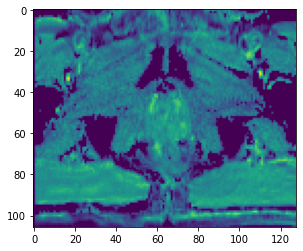

In [13]:
plt.imshow(files_stored_ADC[-1][9])

(80, 80)


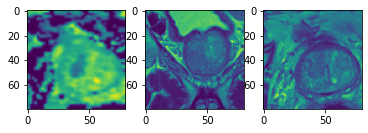

319 319 319


In [14]:
#storing right file into list

files_stored2 = []
files_stored2_tra = []
files_stored2_adc = []


for i in range(len(files_stored_cor)):
    x, y = ijk2[i][0], ijk2[i][1]
    pic = files_stored_cor[i][ijk2[i][2]-1][ijk2[i][1]-size*2:ijk2[i][1]+size*2, ijk2[i][0]-size*2:ijk2[i][0]+size*2]
    pic = cv2.resize(pic,(size*2, size*2))#80, 80
    files_stored2.append(pic)
print(np.asarray(files_stored2[0]).shape)# dimensions ok with all the corrections. 

for i in range(len(files_stored_tra)):
    x, y = ijk[i][0], ijk[i][1]
    pic = files_stored_tra[i][ijk[i][2]-1][ijk[i][1]-size*2:ijk[i][1]+size*2, ijk[i][0]-size*2:ijk[i][0]+size*2]
    pic = cv2.resize(pic,(size*2, size*2))#80, 80
    files_stored2_tra.append(pic)

for i in range(len(files_stored_ADC)):
    x, y = ijk3[i][0], ijk3[i][1]
    pic = files_stored_ADC[i][ijk3[i][2]-1][ijk3[i][1]-20:ijk3[i][1]+20, ijk3[i][0]-20:ijk3[i][0]+20]
    pic = cv2.resize(pic,(size*2, size*2))#80, 80
    files_stored2_adc.append(pic)

n=245-70-1
plt.figure()
plt.subplot(1,3,1)
plt.imshow(files_stored2_adc[n])
plt.subplot(1,3,2)
plt.imshow(files_stored2[n])
plt.subplot(1,3,3)
plt.imshow(files_stored2_tra[n])
plt.show()

print(len(files_stored2), len(files_stored2_adc), len(files_stored2_tra))


In [15]:
#defining the variables

batch_size = 32
img_height = size*2 # 80
img_width = size*2 # 80

In [16]:
for i in range(len(clinsig)):
    print(clinsig[i], clinsig2[i], clinsig3[i])

['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'] ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'] ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE']
['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'] ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'] ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE']
['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE'] ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE'] ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE']
['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE'] ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE'] ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE']
['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE'] ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE'] ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE']
['ProstateX-0

In [17]:
#tensors for data splitting

final = np.zeros((len(files_stored_tra),img_height,img_height,3))

for n in range(len(files_stored2)):
    for i in range(len(files_stored2[0])):
        for j in range(len(files_stored2[0])):
            final[n][i][j][0] = files_stored2[n][i][j]
            final[n][i][j][1] = files_stored2_tra[n][i][j]
            final[n][i][j][2] = files_stored2_adc[n][i][j]
print(final.shape)

category = []
training_data = []
j=0
for i in range(len(clinsig)):
    if clinsig[i][3] == "TRUE":
        category.append(np.asarray([1,0]))
    else:
        category.append(np.asarray([0,1]))
        j +=1
print(len(category), j)#  we have a biais, keep in mind 

for k in range(len(category)):
    training_data.append([final[k], category[k]])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_height, img_width, 3)

y= np.asarray(y)

(319, 80, 80, 3)
319 245


In [18]:
#nmbre for splitting test patients from training patients
nbr = 245

seed = np.random.randint(0, 10000)
print(seed)
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

np.random.seed(seed)
np.random.shuffle(files_stored_cor)
np.random.seed(seed)
np.random.shuffle(files_stored_tra)
np.random.seed(seed)
np.random.shuffle(files_stored_ADC)

np.random.seed(seed)
np.random.shuffle(clinsig)
np.random.seed(seed)
np.random.shuffle(clinsig2)
np.random.seed(seed)
np.random.shuffle(clinsig3)

np.random.seed(seed)
np.random.shuffle(ijk)
np.random.seed(seed)
np.random.shuffle(ijk2)
np.random.seed(seed)
np.random.shuffle(ijk3)

8627


In [19]:
X_test = X[nbr:]
X_test = X_test/255.0
y_test = y[nbr:]

nbr -=70
X_val = X[nbr:nbr+70]
y_val = y[nbr:nbr+70]

print(len(X_val), len(X_test), nbr)
#print(y_val)
for i in range(len(y_val)):
    print(y_val[i], clinsig[nbr+i])

70 74 175
[0 1] ['ProstateX-0172', '1', '-19.9140532625499 31.4812375854275 41.345622424212', 'FALSE']
[0 1] ['ProstateX-0068', '2', '-22.0582 39.112 -11.8622', 'FALSE']
[0 1] ['ProstateX-0161', '1', '-20.6979 60.1012 6.61219', 'FALSE']
[0 1] ['ProstateX-0042', '1', '0.258727 12.1867 29.2257', 'FALSE']
[0 1] ['ProstateX-0149', '1', '19.0337 63.5321 14.5746', 'FALSE']
[0 1] ['ProstateX-0171', '3', '0.425155639648438 40.347412109375 23.8209381103516', 'FALSE']
[0 1] ['ProstateX-0153', '1', '42.0601 33.9525 17.631', 'FALSE']
[0 1] ['ProstateX-0061', '1', '-9.29239 36.6647 29.8906', 'FALSE']
[0 1] ['ProstateX-0072', '1', '-46.3727 5.99356 32.8262', 'FALSE']
[0 1] ['ProstateX-0067', '3', '-11.5378 44.1525 22.7649', 'FALSE']
[1 0] ['ProstateX-0117', '1', '26.7378 24.0652 -34.8602', 'TRUE']
[1 0] ['ProstateX-0195', '1', '-13.0258 7.2252 17.6683', 'TRUE']
[1 0] ['ProstateX-0031', '1', '8.08436 38.9556 13.8648', 'TRUE']
[1 0] ['ProstateX-0202', '1', '-0.02085 -44.5506 16.7349', 'TRUE']
[0 1] ['

In [20]:
for i in range(len(clinsig)):
    print(i,clinsig[i], clinsig2[i], clinsig3[i])

0 ['ProstateX-0194', '1', '-31.1794 27.3023 13.8725', 'TRUE'] ['ProstateX-0194', '1', '-31.1794 27.3023 13.8725', 'TRUE'] ['ProstateX-0194', '1', '-31.1794 27.3023 13.8725', 'TRUE']
1 ['ProstateX-0177', '4', '-5.846966 8.59326 -23.1375', 'FALSE'] ['ProstateX-0177', '4', '-5.846966 8.59326 -23.1375', 'FALSE'] ['ProstateX-0177', '4', '-5.846966 8.59326 -23.1375', 'FALSE']
2 ['ProstateX-0075', '1', '20.1033 33.0877 -65.7973', 'FALSE'] ['ProstateX-0075', '1', '20.1033 33.0877 -65.7973', 'FALSE'] ['ProstateX-0075', '1', '20.1033 33.0877 -65.7973', 'FALSE']
3 ['ProstateX-0142', '2', '52.9462 53.9049 39.3076', 'FALSE'] ['ProstateX-0142', '2', '52.9462 53.9049 39.3076', 'FALSE'] ['ProstateX-0142', '2', '52.9462 53.9049 39.3076', 'FALSE']
4 ['ProstateX-0174', '1', '9.31972 11.9806 2.38443', 'FALSE'] ['ProstateX-0174', '1', '9.31972 11.9806 2.38443', 'FALSE'] ['ProstateX-0174', '1', '9.31972 11.9806 2.38443', 'FALSE']
5 ['ProstateX-0140', '2', '18.8122 40.9708 -20.4472', 'FALSE'] ['ProstateX-014

In [21]:
#equalization function

def equalize(im):   
    hist = np.histogram(im, bins=np.arange(257))[0] 
    c_hist = np.zeros((256,))
    c=0
    for j in range(256):
        c += hist[j]
        c_hist[j] = c
    # Normalize to 0-255 range & convert to integer
    lut_eq = (255*c_hist/c_hist.max()).astype('int')
    im_eq = lut_eq[im]
    return im_eq

In [22]:
def data_augmentation(files_stored_ct, clinsig, ijk2, resize):
    # Data augmentation
    data_augmented_ct = []
    category_augmented_ct = []
    training_data_augmented_ct = []
    ones=0
    zeros=0

    if resize:
        shiftx = 10
        shifty = -10
    else:
        shiftx = 5
        shifty = -5

    for i in range(len(files_stored_ct[:nbr])):
        #x, y = ijk[i][0], ijk[i][1]
        if clinsig[i][3] == "TRUE":
            #biasing problem
            category_augmented_ct.append(np.asarray([1,0]))#category_augmented.append([0,1])
            if resize:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size*2:ijk2[i][1]+size*2, ijk2[i][0]-size*2:ijk2[i][0]+size*2]
                pic = cv2.resize(pic,(size*2, size*2))
            else:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
                pic = cv2.resize(pic,(size*2, size*2))
            data_augmented_ct.append(pic)
            ones +=1

            category_augmented_ct.append(np.asarray([1,0]))
            if resize:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size*2+shiftx:ijk[i][1]+size*2+shiftx, ijk2[i][0]-size*2+shifty:ijk2[i][0]+size*2+shifty]
                pic2 = cv2.resize(pic2,(size*2, size*2))
            else:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20+shifty:ijk2[i][0]+20+shifty]
                pic2 = cv2.resize(pic2,(size*2, size*2))
            data_augmented_ct.append(pic2)
            ones +=1

            category_augmented_ct.append(np.asarray([1,0]))
            if resize:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size*2-shiftx:ijk2[i][1]+size*2-shiftx, ijk2[i][0]-size*2-shifty:ijk2[i][0]+size*2-shifty]
                pic3 = cv2.resize(pic3,(size*2, size*2))
            else:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20-shiftx:ijk2[i][1]+20-shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
                pic3 = cv2.resize(pic3,(size*2, size*2))
            data_augmented_ct.append(pic3)
            ones +=1

            category_augmented_ct.append(np.asarray([1,0]))
            if resize:
                pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size*2+shiftx:ijk2[i][1]+size*2+shiftx, ijk2[i][0]-size*2-shifty:ijk2[i][0]+size*2-shifty]
                pic4 = cv2.resize(pic4,(size*2, size*2))
            else:
                pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
                pic4 = cv2.resize(pic4,(size*2, size*2))
            data_augmented_ct.append(pic4)
            ones +=1

            #dimming brightness
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.25
            pic62 = pic2/1.25
            pic63 = pic3/1.25
            pic64 = pic4/1.25
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic64)
            ones +=1
            
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.5
            pic62 = pic2/1.5
            pic63 = pic3/1.5
            pic64 = pic4/1.5
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic64)
            ones +=1
            
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.1
            pic62 = pic2/1.1
            pic63 = pic3/1.1
            pic64 = pic4/1.1
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic64)
            ones +=1

            #Rotating
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 15, reshape=False))
            ones+=1
            
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic4, 15, reshape=False))
            ones+=1
            
            #Contrast enhancement
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic2))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic3))
            ones+=1
            
            
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic4))
            ones+=1
            
            #Gaussian filter
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic, sigma=0.7))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic2, sigma=0.7))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic3, sigma=0.7))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic4, sigma=0.7))
            ones+=1

        else:
            category_augmented_ct.append(np.asarray([0,1]))
            if resize:
                #print(np.asarray(files_stored_ct[i]).shape, ijk2[i], ijk2[i][1]-size*2, ijk2[i][1]+size*2, ijk2[i][0]-size*2, ijk2[i][0]+size*2)
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size*2:ijk2[i][1]+size*2, ijk2[i][0]-size*2:ijk2[i][0]+size*2]
                pic = cv2.resize(pic,(size*2, size*2))
            else:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
                pic = cv2.resize(pic,(size*2, size*2))
            data_augmented_ct.append(pic)
            zeros +=1

            
            #dimming brightness
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.25
            data_augmented_ct.append(pic2)

            zeros +=1
            
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.5
            data_augmented_ct.append(pic2)
            zeros +=1
            
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.1
            data_augmented_ct.append(pic2)
            zeros +=1

            #Rotating
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            zeros+=1

            #Contrast enhancement
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(equalize(pic))
            zeros+=1
            
            #Gaussian filter
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic, sigma=0.7))
            zeros+=1
            
    return category_augmented_ct, data_augmented_ct, ones, zeros

print(len(files_stored_tra), len(files_stored_cor), len(files_stored_ADC))
print(len(ijk), len(ijk2), len(ijk3))
print(len(clinsig), len(clinsig2), len(clinsig3))
print(nbr)

category_ct, data_ct, on, zer = data_augmentation(files_stored_cor, clinsig2, ijk2, True)
category, data, on, zer = data_augmentation(files_stored_tra, clinsig, ijk, True)
category_ADC, data_ADC, on, zer = data_augmentation(files_stored_ADC, clinsig3, ijk3, False)


print(len(category), len(data), len(category_ct), len(data_ct))

319 319 319
319 319 319
319 319 319
175
3684 3684 3684 3684


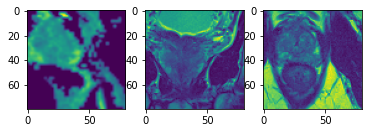

[0 1] [0 1] [0 1]
3684 3684 2112 1572
3684 3684 2112 1572
3684 3684 2112 1572


In [23]:
#visualizing the data

n= -11
plt.figure()
plt.subplot(1,3,1)
plt.imshow(data_ADC[n])
plt.subplot(1,3,2)
plt.imshow(data_ct[n])
plt.subplot(1,3,3)
plt.imshow(data[n])
plt.show()


data_augmented_ct = data_ct
category_augmented_ct = category_ct
category_augmented = category
data_augmented = data
category_augmented_ADC = category_ADC
data_augmented_ADC = data_ADC

print(category_augmented_ct[n], category_augmented_ADC[n], category_augmented[n])
print(len(data_augmented_ct), len(category_augmented_ct), on, zer)
print(len(data_augmented), len(category_augmented), on, zer)
print(len(data_augmented_ADC), len(category_augmented_ADC), on, zer)

In [24]:
#final list

print(np.asarray(data_augmented).shape)
final = np.zeros((np.asarray(data_augmented).shape[0],size*2
                  ,size*2,3))

for n in range(len(data_augmented)):
    for i in range(len(data_augmented[0])):
        for j in range(len(data_augmented[0])):
            final[n][i][j][0] = data_augmented_ct[n][i][j]
            final[n][i][j][1] = data_augmented[n][i][j]
            final[n][i][j][2] = data_augmented_ADC[n][i][j]
print(final.shape)

(3684, 80, 80)
(3684, 80, 80, 3)


In [25]:
#final tensors

training_data_augmented = []

for k in range(len(category_augmented)):
    training_data_augmented.append([final[k], category_augmented[k]])
    
random.shuffle(training_data_augmented)
print(len(training_data_augmented), k+1)
X = []
y = []

for features,label in training_data_augmented:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 3)

y = np.asarray(y)

print(X.shape)

3684 3684
(3684, 80, 80, 3)


In [26]:
print(y)

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [27]:
#saving the data

'''
pickle_out = open("base/X_combined_tra_ADC.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("base/y_combined_tra_ADC.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()
'''

'\npickle_out = open("base/X_combined_tra_ADC.pickle","wb")\npickle.dump(X, pickle_out)\npickle_out.close()\n\npickle_out = open("base/y_combined_tra_ADC.pickle","wb")\npickle.dump(y, pickle_out)\npickle_out.close()\n'

In [28]:
'''
pickle_in = open("base/X_combined_tra_ADC.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("base/y_combined_tra_ADC.pickle","rb")
y = pickle.load(pickle_in)

y = np.asarray(y)

print(X.shape[1:])
'''

'\npickle_in = open("base/X_combined_tra_ADC.pickle","rb")\nX = pickle.load(pickle_in)\n\npickle_in = open("base/y_combined_tra_ADC.pickle","rb")\ny = pickle.load(pickle_in)\n\ny = np.asarray(y)\n\nprint(X.shape[1:])\n'

In [29]:
#normalizing the data

X = X/255.0
print(X.shape)

(3684, 80, 80, 3)


In [30]:
#split between true and false

pos=0
for i in range(len(y_val)):
    if y_val[i][0]==1:
        pos +=1 
print(pos/len(y_val))

0.24285714285714285


In [32]:
from tensorflow.keras.layers import BatchNormalization

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

filepath = "saved_model/best_weights"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [33]:
#balancing the validation set

x_t=[]
y_t=[]
for i in range(len(X_val)):
    if y_val[i][0]==1:
        x_t.append(X_val[i])
        y_t.append(y_val[i])

n = len(x_t)*2
while len(y_t) <n:
    if y_val[i][0]==0:
        x_t.append(X_val[i])
        y_t.append(y_val[i])

x_t = np.array(x_t).reshape(-1, img_height, img_width, 3)
y_t = np.asarray(y_t)
np.random.seed(seed)
np.random.shuffle(x_t)
np.random.shuffle(y_t)
print(y_t)
print(np.asarray(y_t).shape, np.asarray(x_t).shape)

[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
(34, 2) (34, 80, 80, 3)


In [39]:
#CNN

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',#,loss='mse'
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(X, y, batch_size=32, epochs=30, validation_data=(x_t,y_t), shuffle=True,callbacks=[model_checkpoint_callback])#,callbacks=[callback])#model_checkpoint_callback, 50, 

Epoch 1/30
116/116 [==============================] - 10s 80ms/step - loss: 0.7208 - accuracy: 0.5591 - val_loss: 114.4891 - val_accuracy: 0.5294
Epoch 2/30
116/116 [==============================] - 9s 78ms/step - loss: 0.7349 - accuracy: 0.6664 - val_loss: 136.3917 - val_accuracy: 0.5882
Epoch 3/30
116/116 [==============================] - 9s 78ms/step - loss: 1.1281 - accuracy: 0.7031 - val_loss: 211.7689 - val_accuracy: 0.5000
Epoch 4/30
116/116 [==============================] - 9s 79ms/step - loss: 0.5882 - accuracy: 0.7497 - val_loss: 313.0653 - val_accuracy: 0.5294
Epoch 5/30
116/116 [==============================] - 9s 78ms/step - loss: 0.7900 - accuracy: 0.7470 - val_loss: 346.0214 - val_accuracy: 0.5294
Epoch 6/30
116/116 [==============================] - 9s 78ms/step - loss: 0.5630 - accuracy: 0.7960 - val_loss: 736.0165 - val_accuracy: 0.4706
Epoch 7/30
116/116 [==============================] - 9s 78ms/step - loss: 0.6856 - accuracy: 0.7960 - val_loss: 2510.4268 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


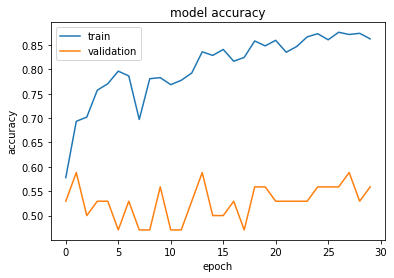

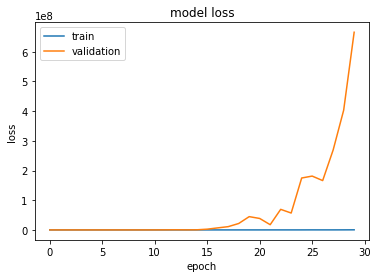

In [46]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('pic/model_history_combined_acc_tra')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('pic/model_history_combined_loss_tra')
plt.show()

In [45]:
#model.save('saved_model/model_combined_tra')

/Users/langletmaxime/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/langletmaxime/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/model_combined_tra/assets


In [ ]:
#model = Sequential()
#model = tf.keras.models.load_model('saved_model/model_combined')
#model.summary()

In [ ]:
portion = int(X.shape[0]*0.8)
print(X.shape[0]-portion)
model.evaluate(X[portion:],y[portion:])
predict = model.predict(X[portion:])
for i in range(608):
    print(predict[i], y[portion+i])

In [ ]:
con = confusion_matrix(labels=y[portion:,0], predictions=predict[:,0]>0.5)

print(con)

#vrai negatif  faux positif
#faux negatif  vrai positif

In [41]:
#evaluation of model
model.evaluate(X_test,y_test)
predict = model.predict(X_test)

for i in range(len(predict)):
    if round(predict[i][0]) != y_test[i][0]:
        print(i, predict[i], y_test[i])

3/3 [==============================] - 0s 22ms/step - loss: 2384644.0000 - accuracy: 0.5541
0 [1. 0.] [0 1]
1 [1. 0.] [0 1]
4 [1. 0.] [0 1]
5 [1. 0.] [0 1]
7 [0. 1.] [1 0]
9 [1. 0.] [0 1]
18 [0. 1.] [1 0]
21 [1. 0.] [0 1]
22 [1. 0.] [0 1]
23 [0. 1.] [1 0]
24 [0. 1.] [1 0]
29 [1. 0.] [0 1]
38 [1. 0.] [0 1]
39 [1. 0.] [0 1]
40 [1. 0.] [0 1]
44 [1. 0.] [0 1]
47 [1. 0.] [0 1]
48 [1. 0.] [0 1]
49 [1. 0.] [0 1]
52 [1. 0.] [0 1]
53 [0. 1.] [1 0]
54 [1. 0.] [0 1]
57 [1. 0.] [0 1]
59 [1. 0.] [0 1]
60 [1. 0.] [0 1]
61 [1. 0.] [0 1]
62 [1. 0.] [0 1]
63 [1. 0.] [0 1]
65 [0. 1.] [1 0]
66 [1. 0.] [0 1]
67 [0. 1.] [1 0]
69 [1. 0.] [0 1]
70 [1. 0.] [0 1]


In [42]:
#confusion matrix

con = confusion_matrix(labels=y_test[:,0], predictions=predict[:,0]>0.5)
print(con)

tf.Tensor(
[[35 26]
 [ 7  6]], shape=(2, 2), dtype=int32)


In [43]:
pickle_out = open("base/X_comb_test_tra_ADC.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("base/y_comb_test_tra_ADC.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [44]:
pickle_in = open("base/X_comb_test_tra_ADC.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("base/y_comb_test_tra_ADC.pickle","rb")
y_test = pickle.load(pickle_in)

y_test = np.asarray(y_test)

print(X_test.shape[:])

(74, 80, 80, 3)


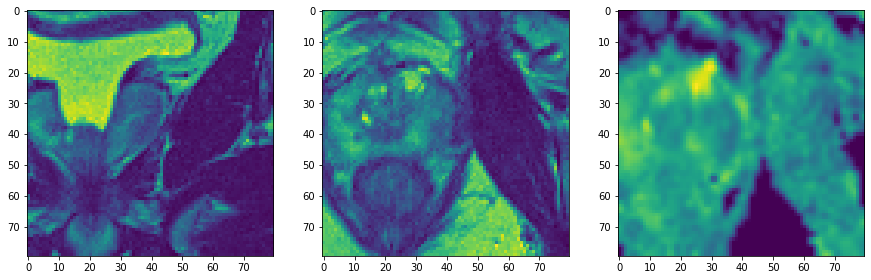

In [49]:
n=61#16
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(X_test[n][:,:,0])
plt.subplot(1,3,2)
plt.imshow(X_test[n][:,:,1])
plt.subplot(1,3,3)
plt.imshow(X_test[n][:,:,2])
plt.show()

[1 0]


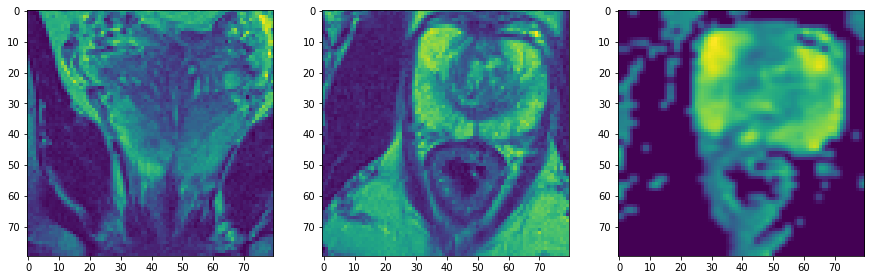

[0 1]


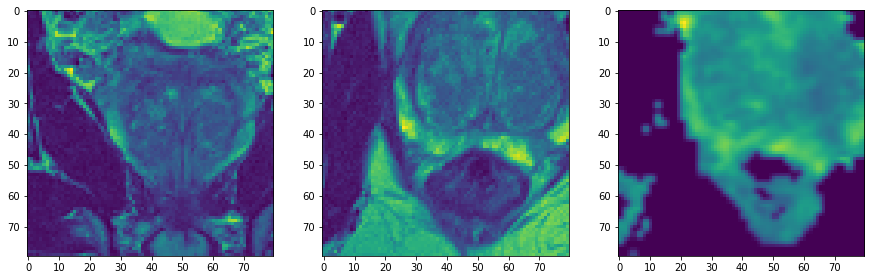

[0 1]


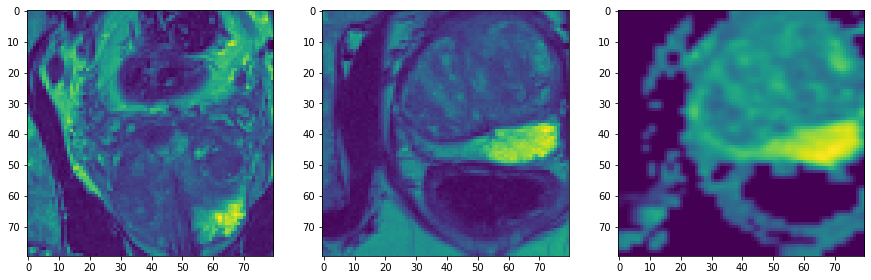

[0 1]


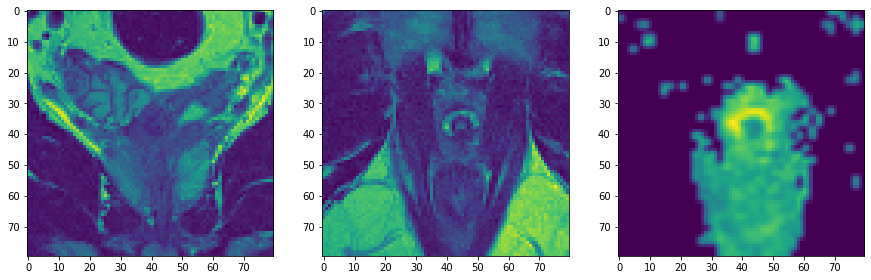

[0 1]


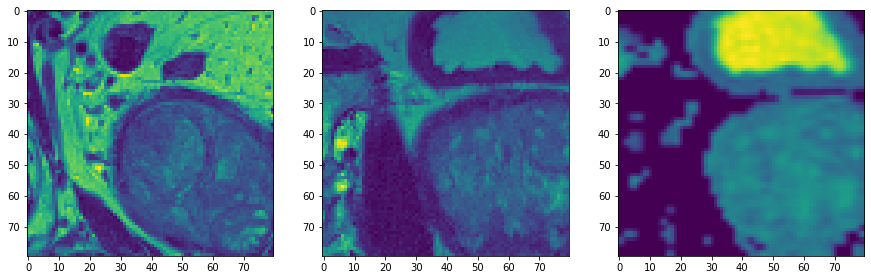

[0 1]


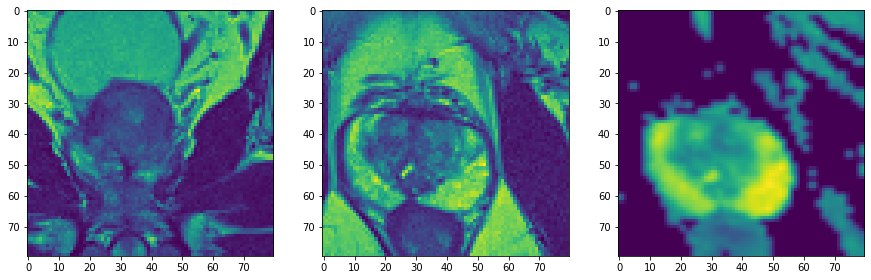

[1 0]


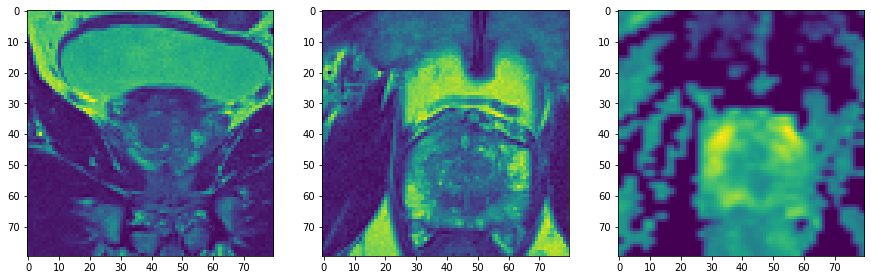

[0 1]


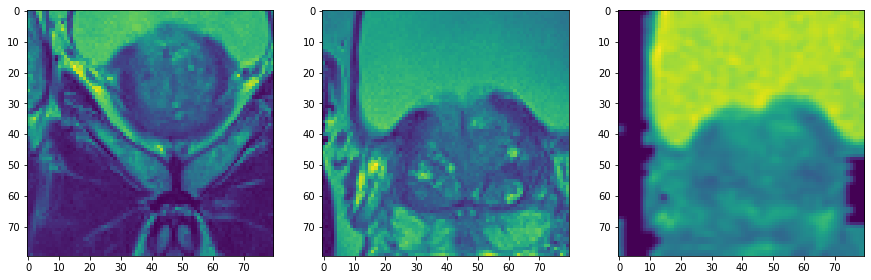

[0 1]


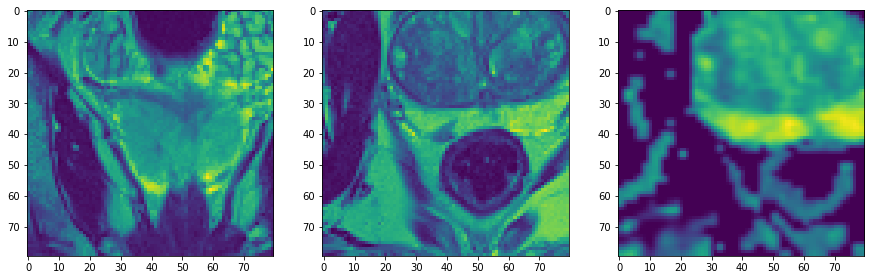

[1 0]


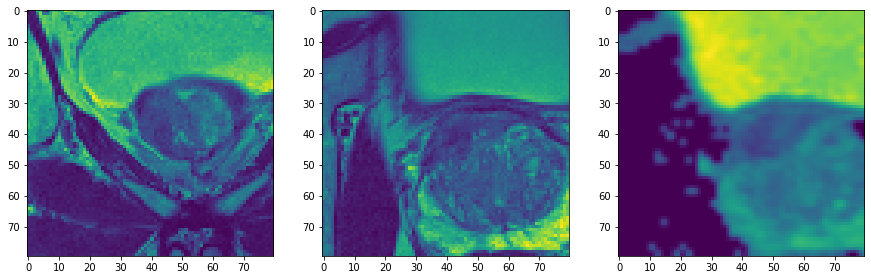

[0 1]


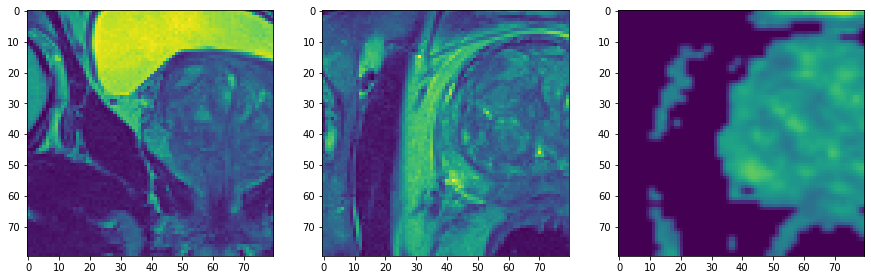

[1 0]


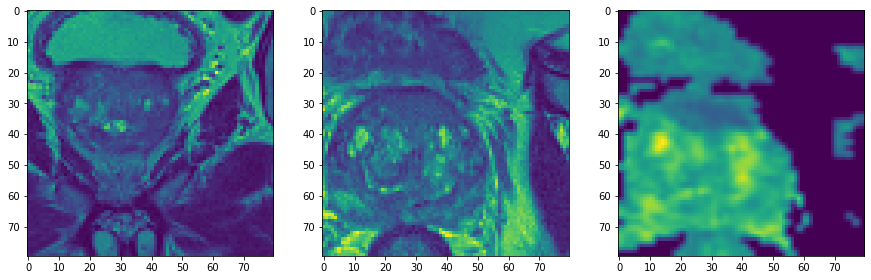

[0 1]


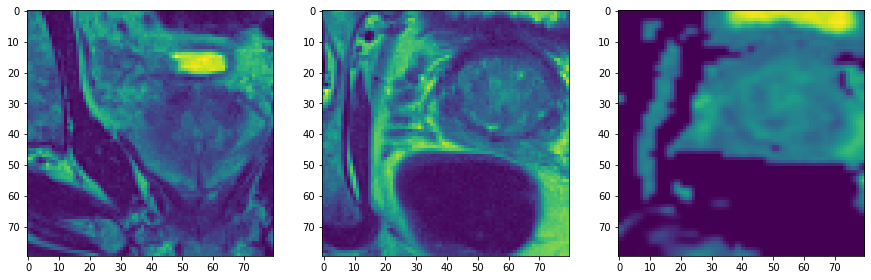

[0 1]


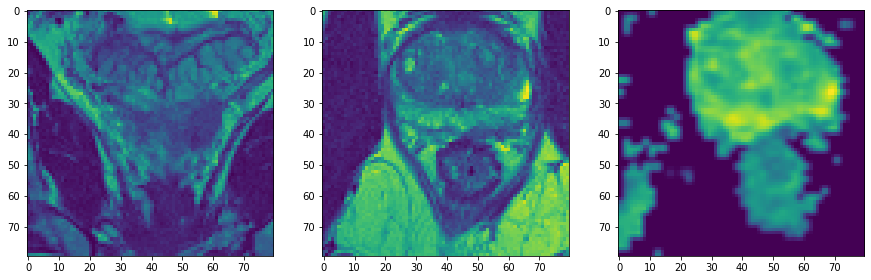

[0 1]


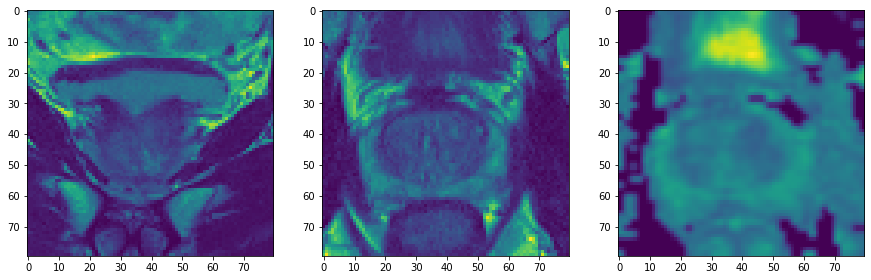

[1 0]


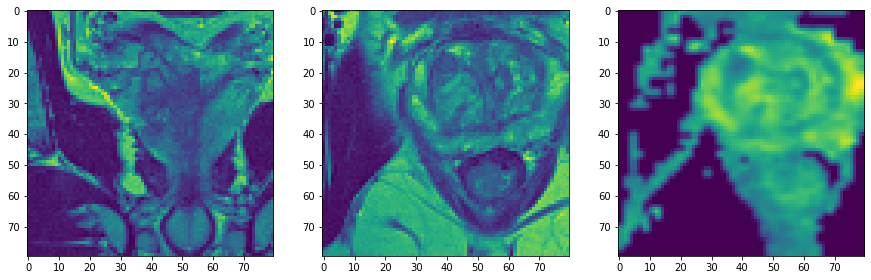

[0 1]


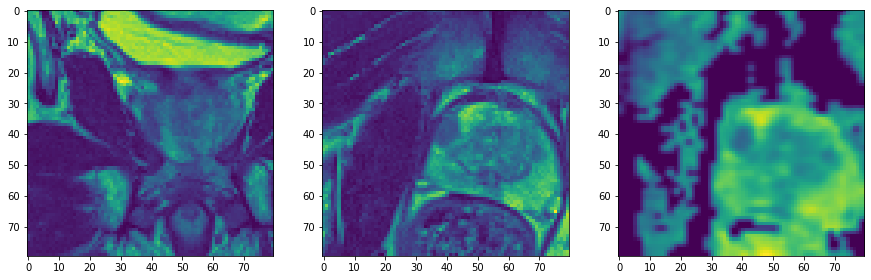

[0 1]


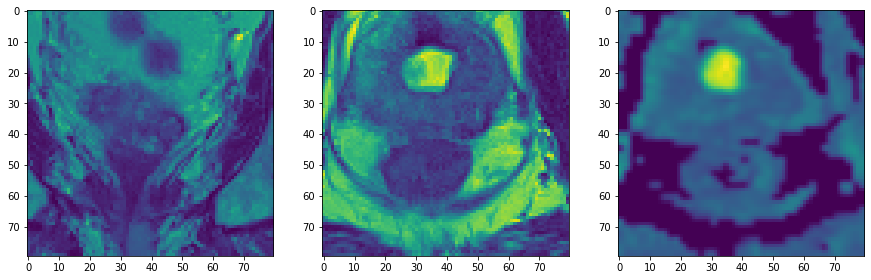

[0 1]


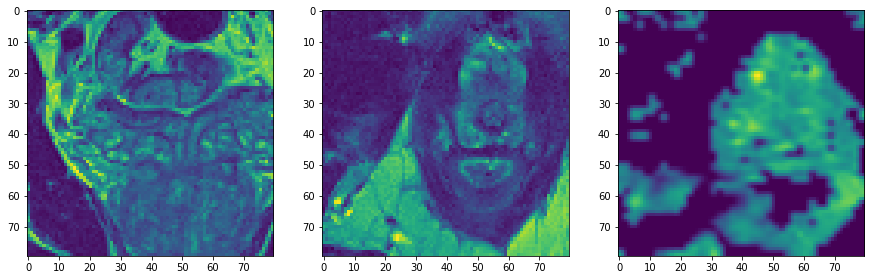

[0 1]


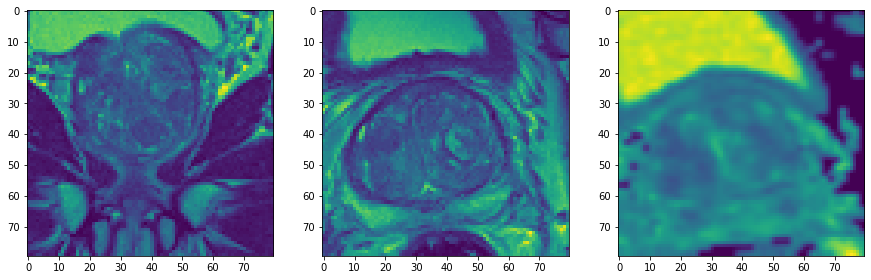

[0 1]


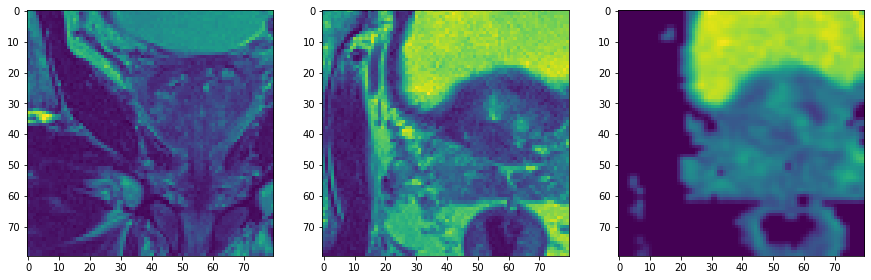

[1 0]


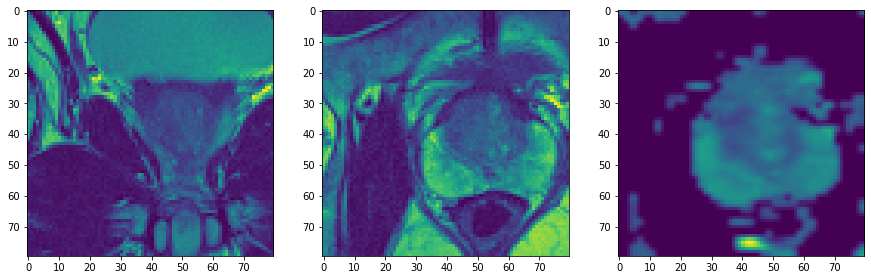

[0 1]


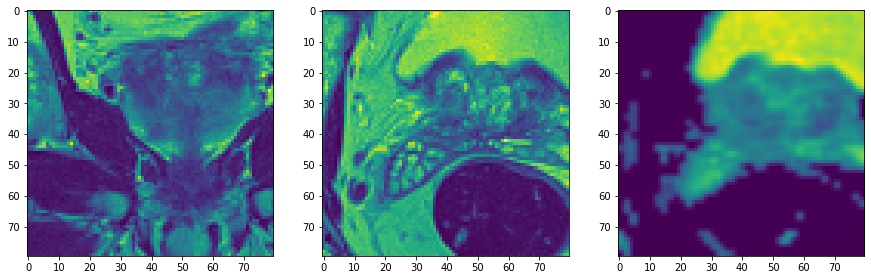

[0 1]


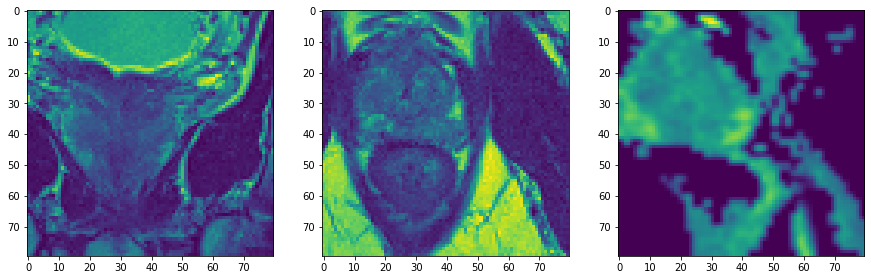

[0 1]


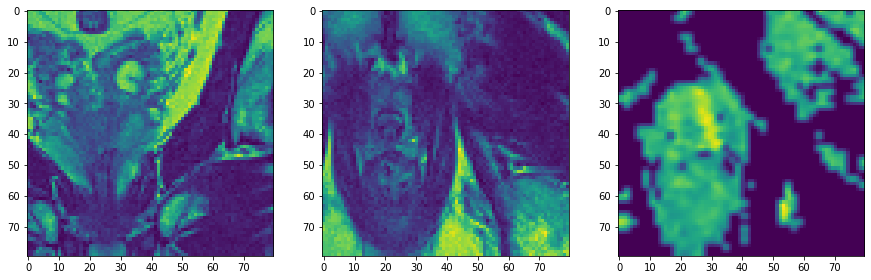

[0 1]


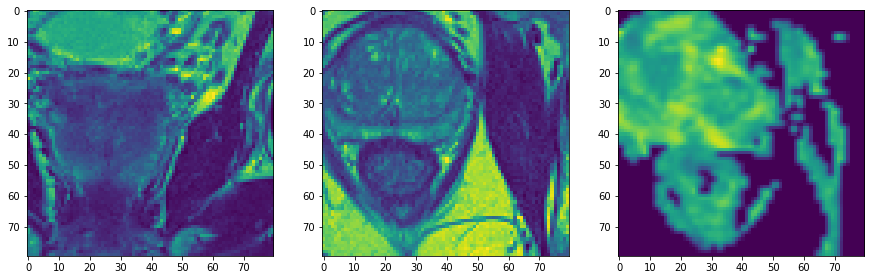

[0 1]


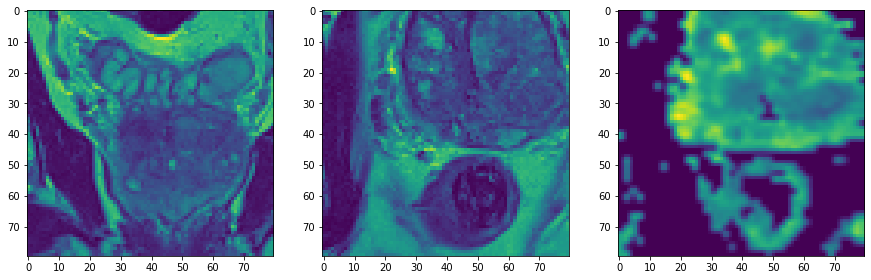

[0 1]


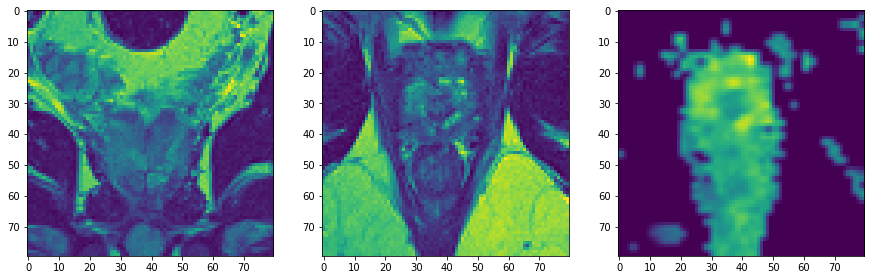

[0 1]


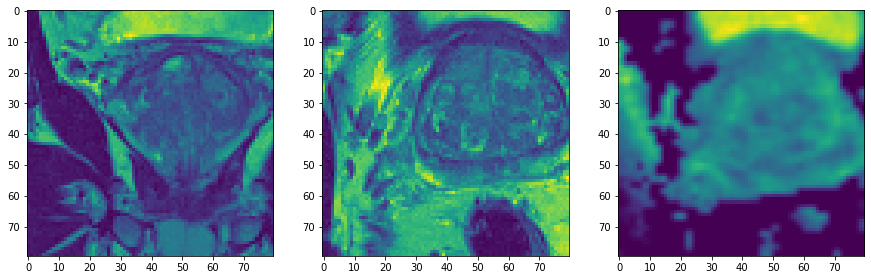

[0 1]


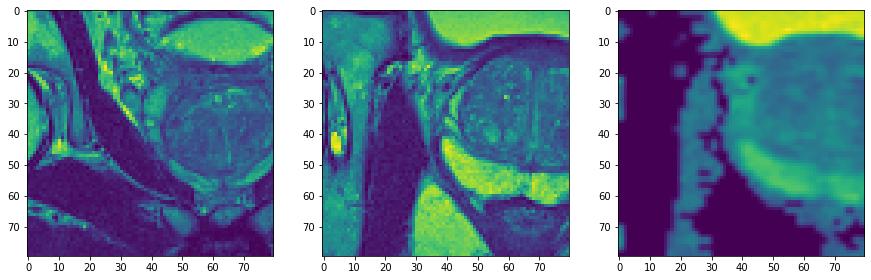

[1 0]


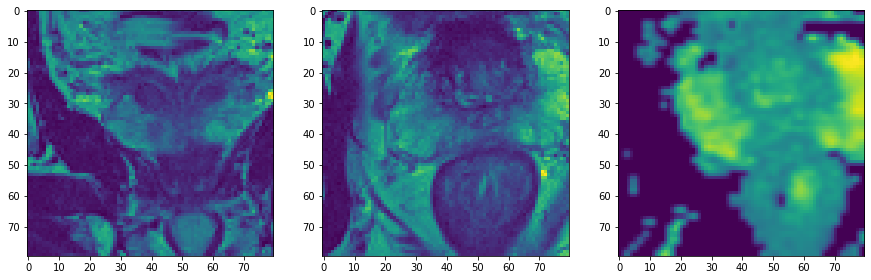

[0 1]


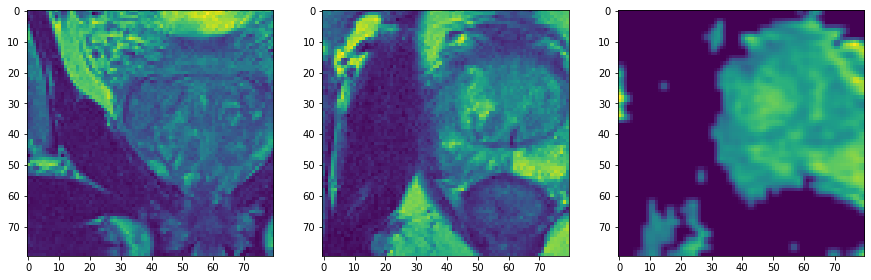

[0 1]


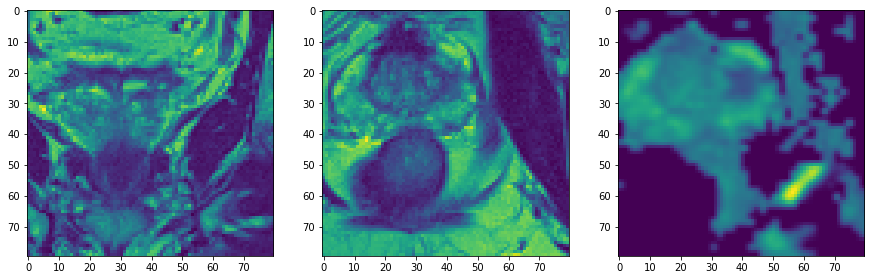

[1 0]


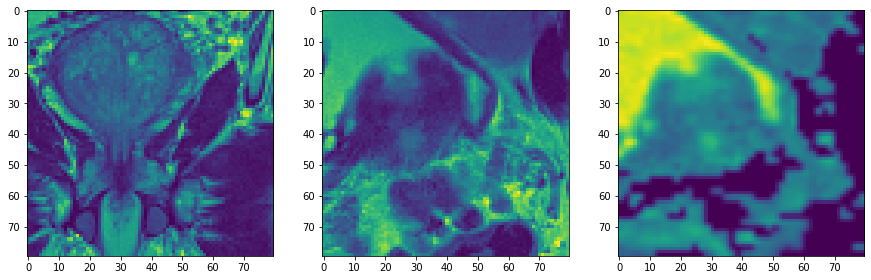

[0 1]


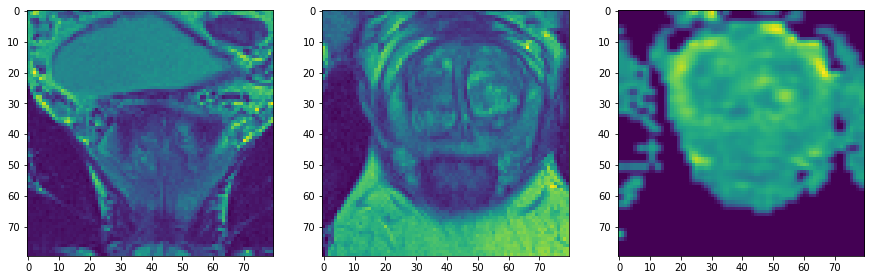

[0 1]


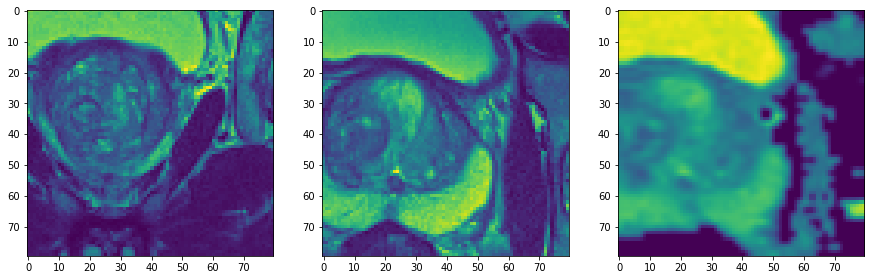

[0 1]


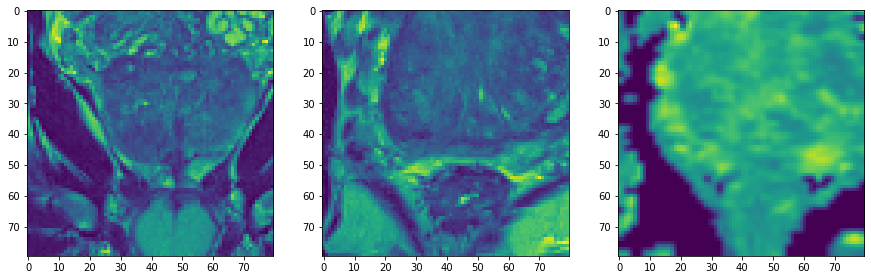

[0 1]


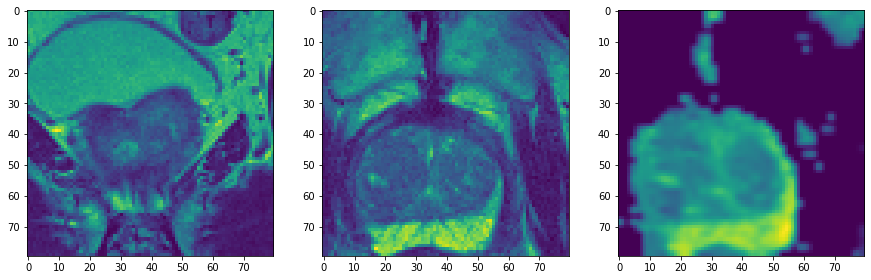

[1 0]


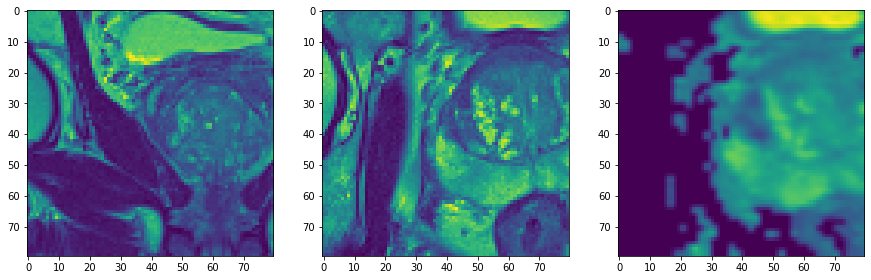

[0 1]


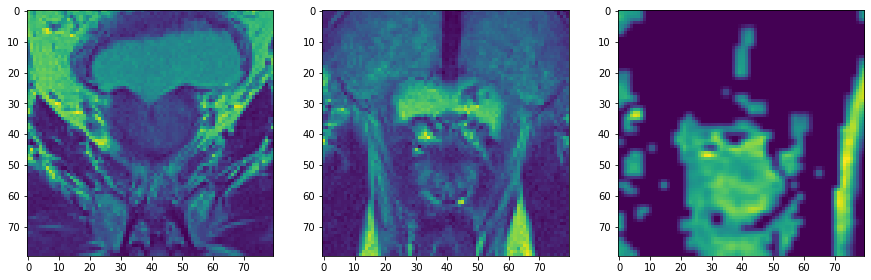

[0 1]


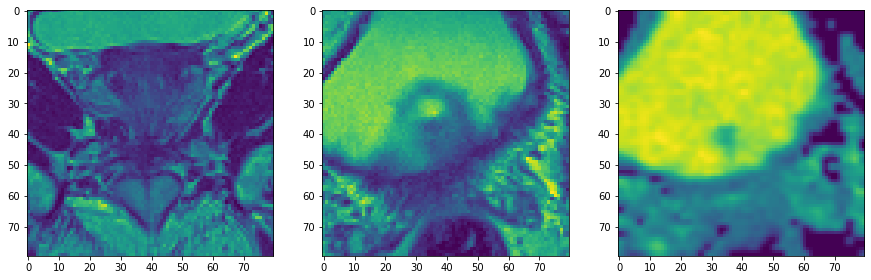

[0 1]


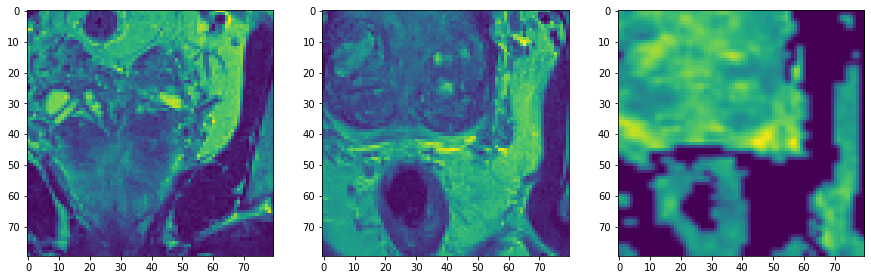

[1 0]


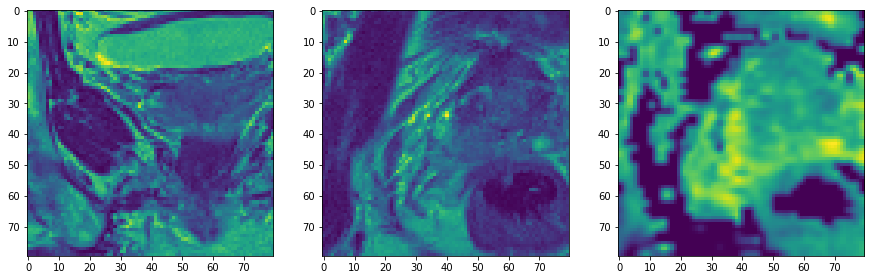

[0 1]


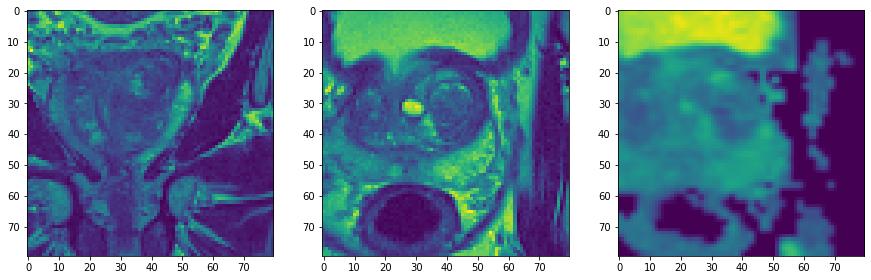

[0 1]


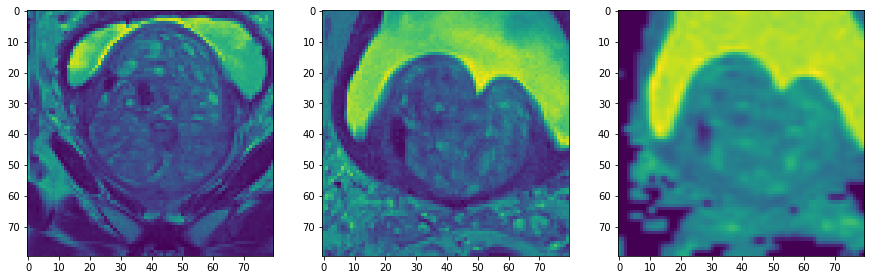

[0 1]


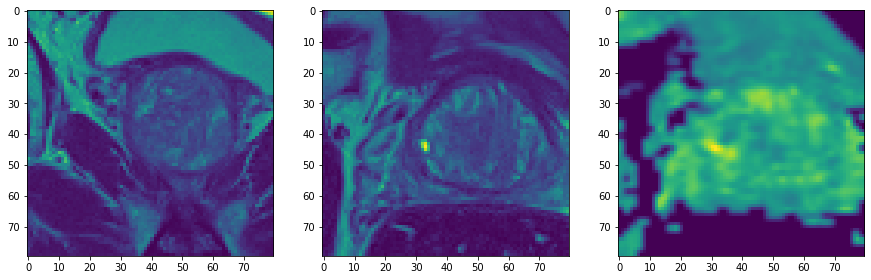

[1 0]


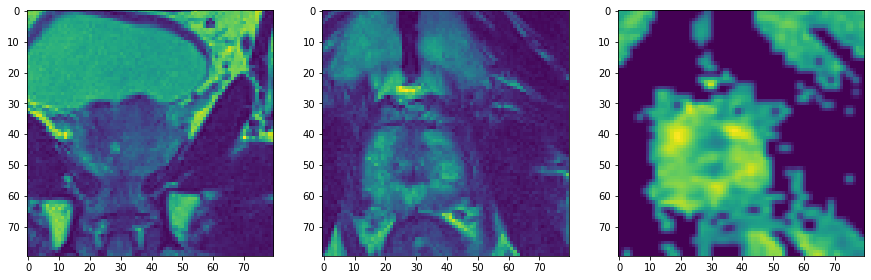

[1 0]


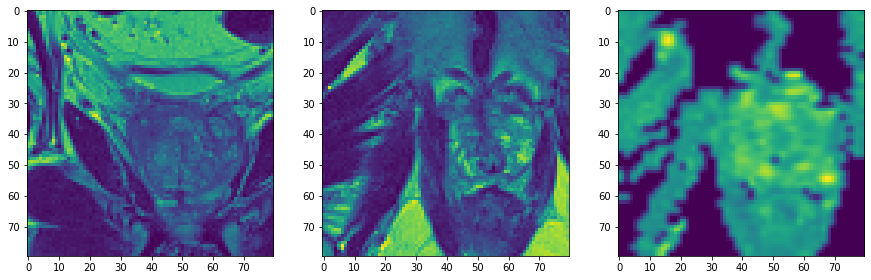

[0 1]


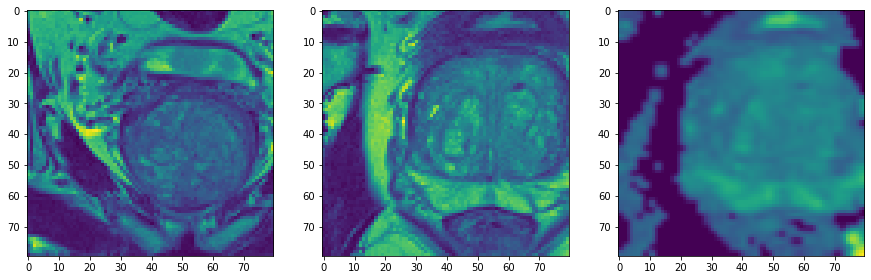

[1 0]


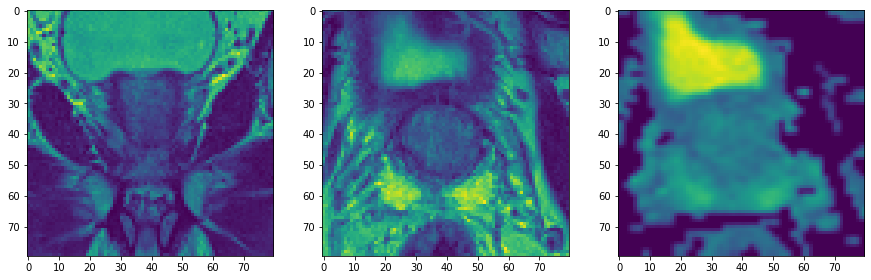

[0 1]


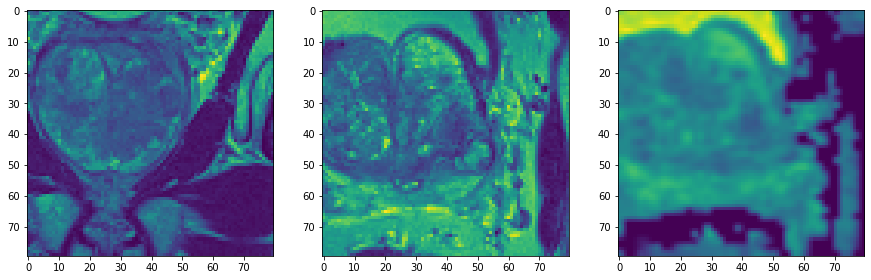

[0 1]


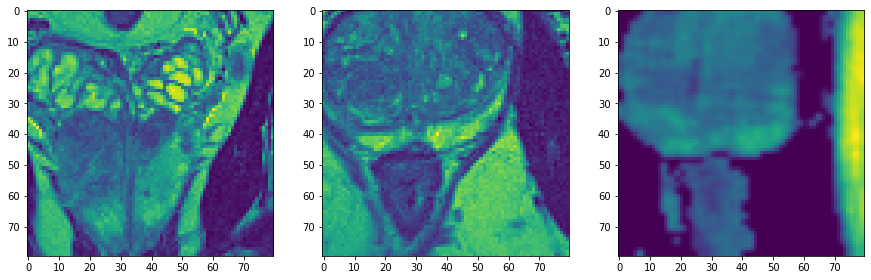

[0 1]


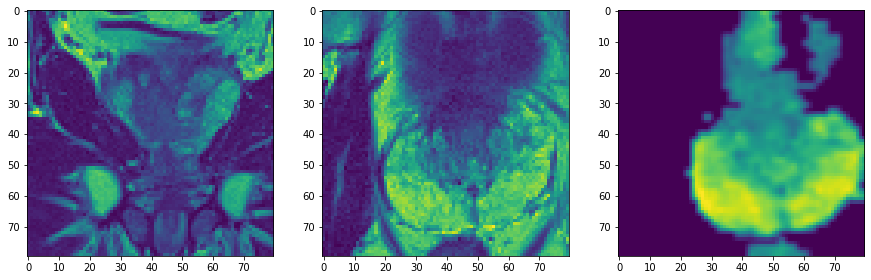

[0 1]


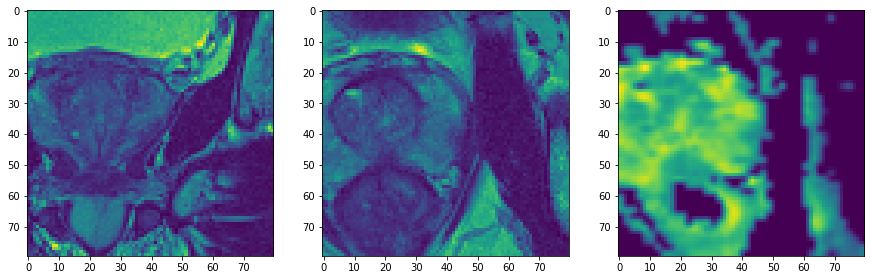

[0 1]


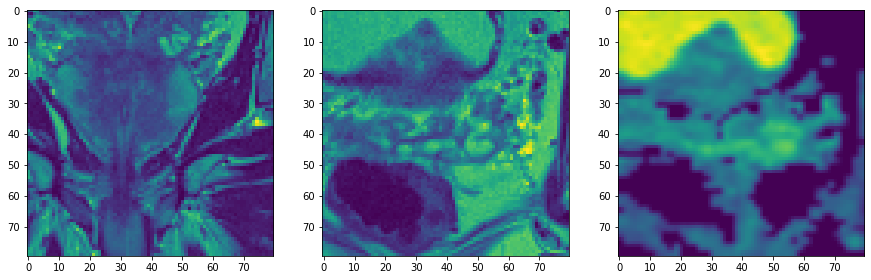

[1 0]


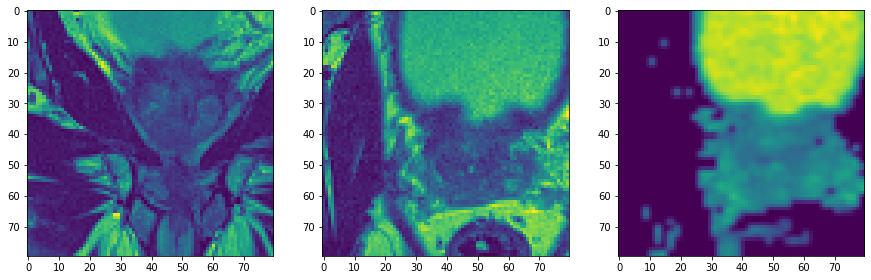

[0 1]


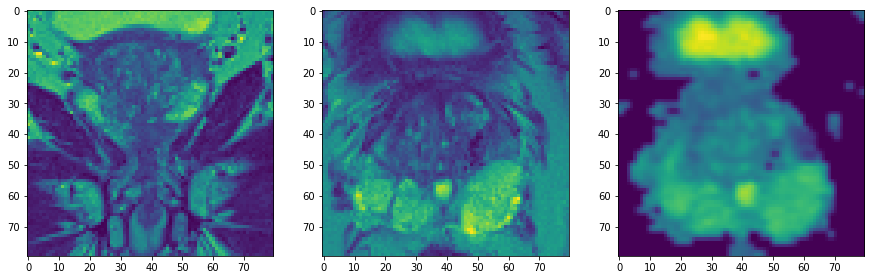

[1 0]


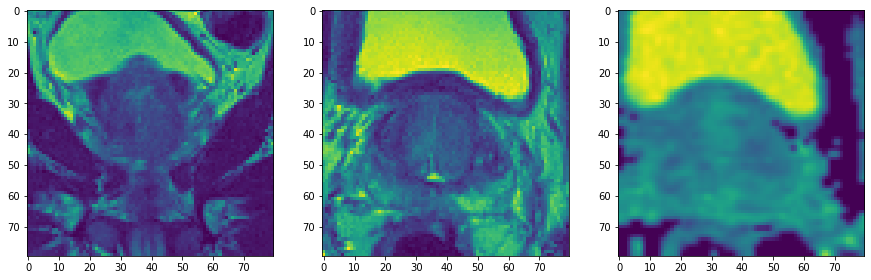

[1 0]


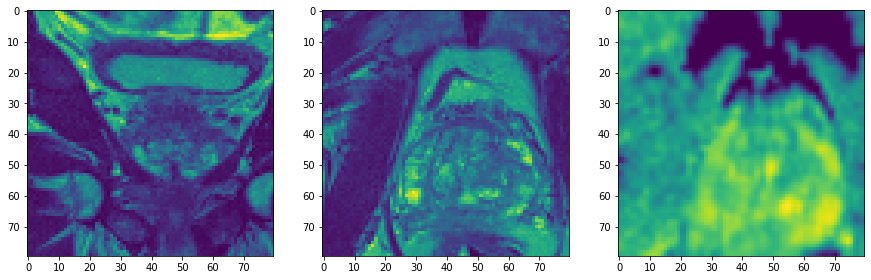

[0 1]


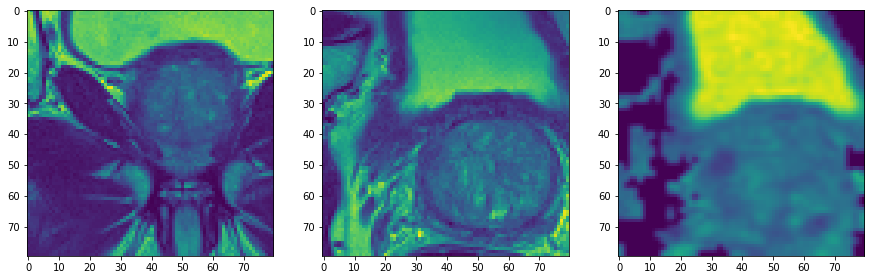

[1 0]


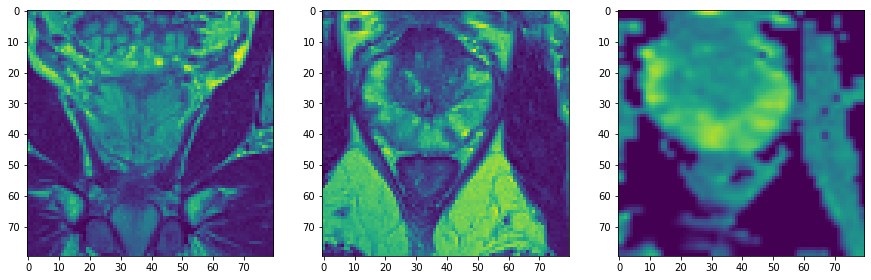

[1 0]


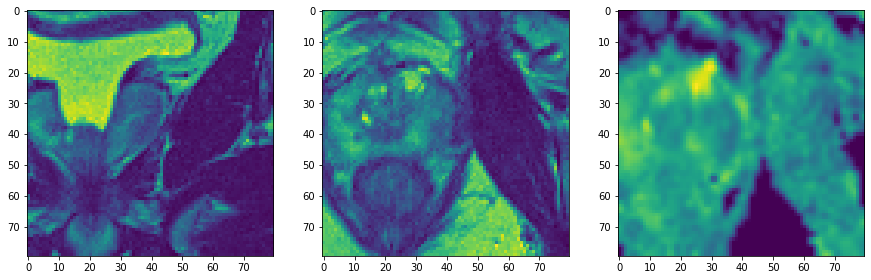

[1 0]


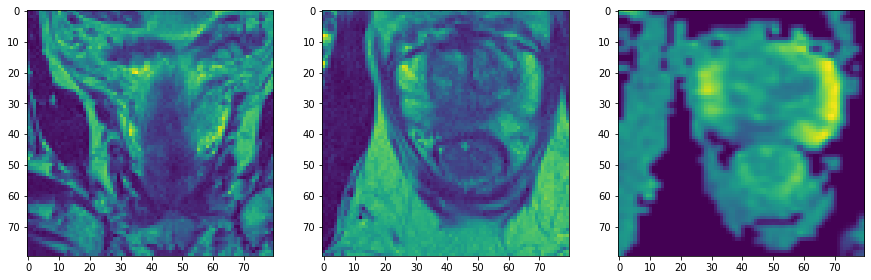

[1 0]


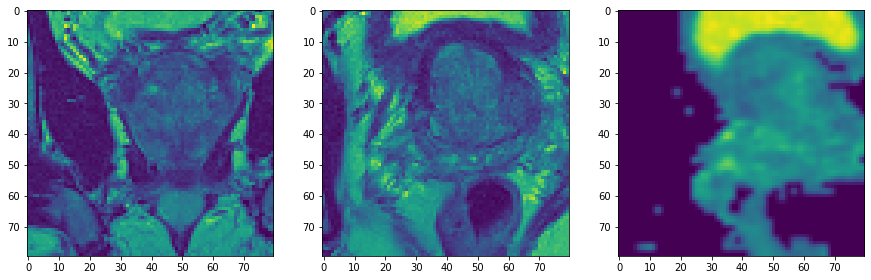

[1 0]


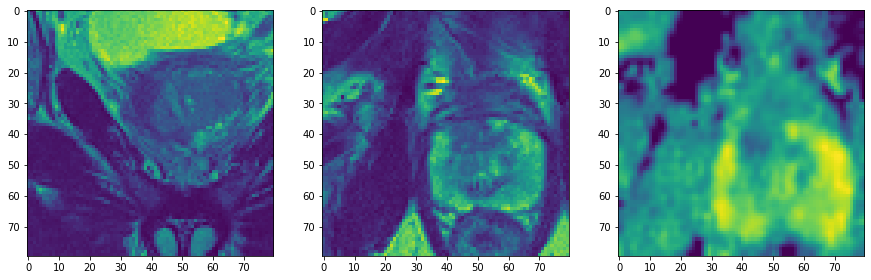

[0 1]


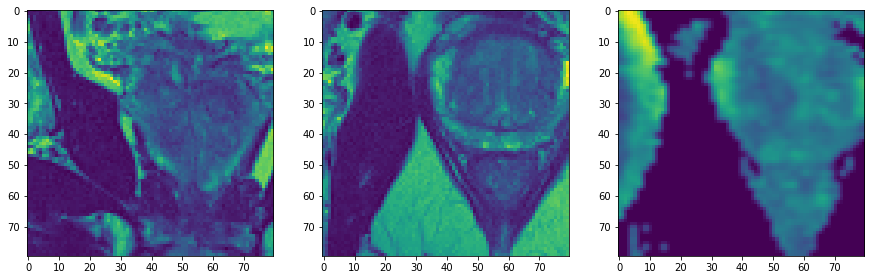

[0 1]


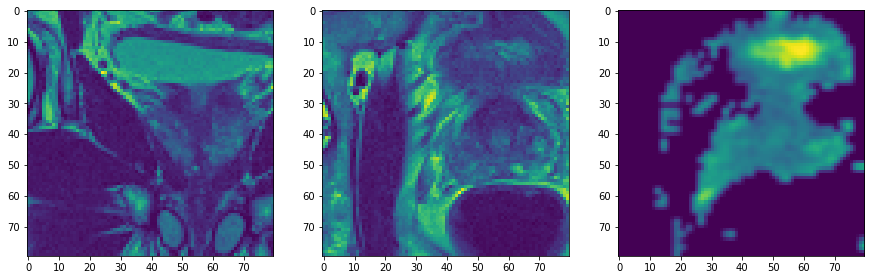

[0 1]


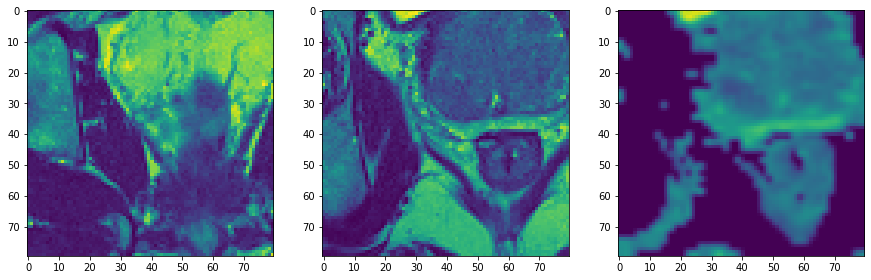

[0 1]


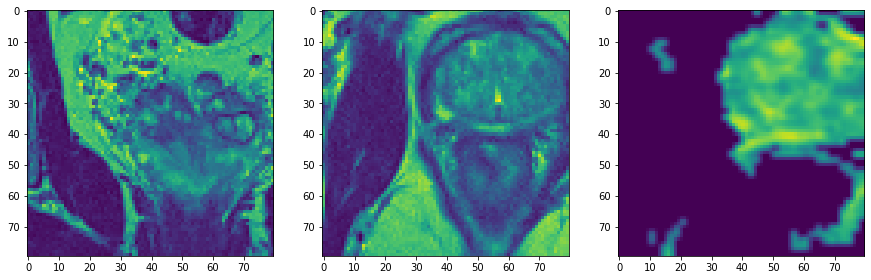

[0 1]


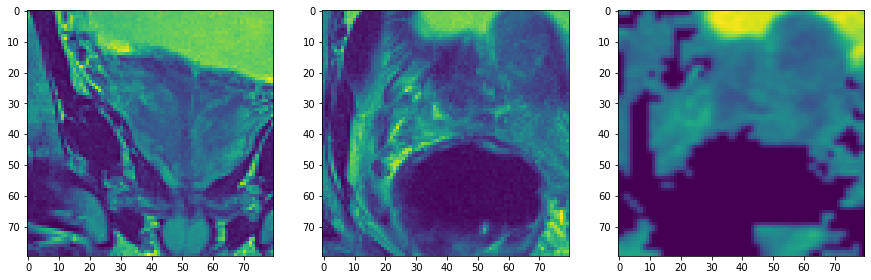

[0 1]


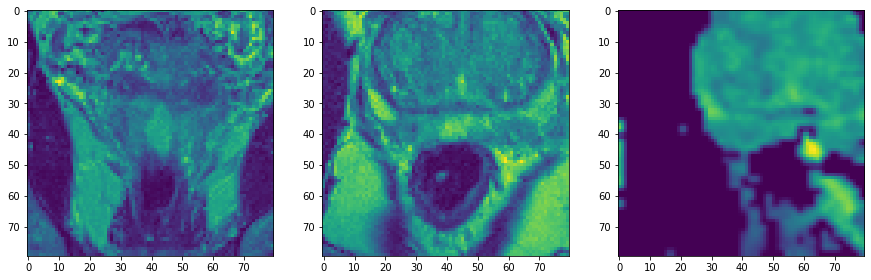

[0 1]


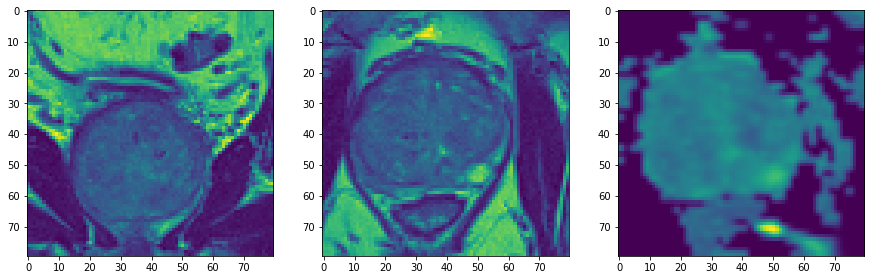

[1 0]


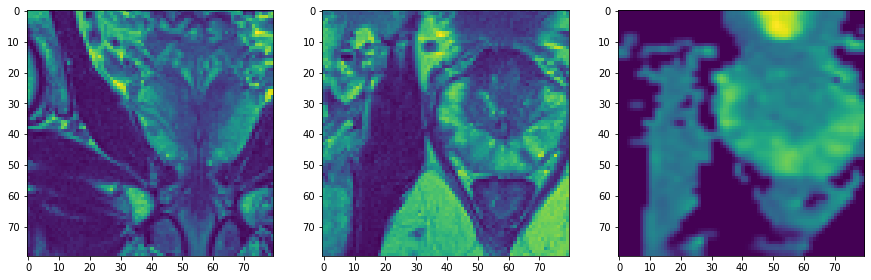

[0 1]


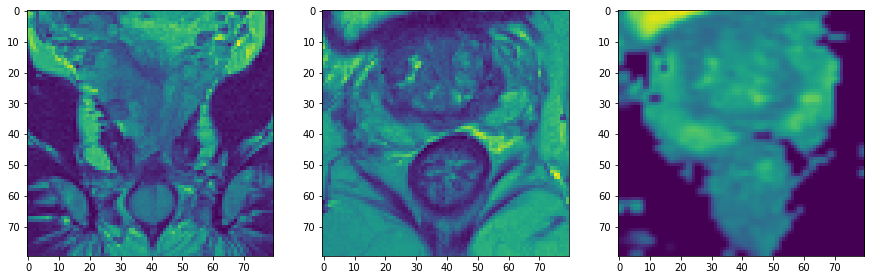

In [64]:
#visualization for analysis

x = [10,16,23,24,33,39,40,44,52,56,58,61,66,68]
y = 0
y2 = 0
for i in range(len(X_test)):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(X_test[i][:,:,0])
    plt.subplot(1,3,2)
    plt.imshow(X_test[i][:,:,1])
    plt.subplot(1,3,3)
    plt.imshow(X_test[i][:,:,2])
    if i not in x:
        if round(predict[i][0]) == y_test[10][0]:
            name="good_neg"
        else:
            name="good_pos"
        plt.savefig("Results/good/"+name+str(y))
        y+=1
    else:
        if round(predict[i][0]) == y_test[10][0]:
            name="bad_pos"
        else:
            name="bad_neg"
        plt.savefig("Results/bad/"+name+str(y2))
        y2+=1
    print(y_test[i])
    plt.show()